In [41]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

%matplotlib inline

In [42]:
# Read in data from CSV into a Spark data frame
#sc = SparkContext()
sqlContext = SQLContext(sc)

In [43]:
FEATURES_COL = ['_c2', '_c3', '_c4', '_c5', '_c6', '_c7']
path = 'mysql_commentator_profile.csv'

df = sqlContext.read.csv(path, header=False) # requires spark 2.0
df.show()
df.count()

+---+---------------+---+---+---+---+---+---+
|_c0|            _c1|_c2|_c3|_c4|_c5|_c6|_c7|
+---+---------------+---+---+---+---+---+---+
|  1|     吃比瘦有福| 11|  0|  0|  0|  2|  0|
|  2| Nash，神之領域| 16|  3|  0|  0|  1|  3|
|  3|           張小| 38|  1|  1|  2|  5| 15|
|  4|         快樂瑜| 12|  2|  0|  0|  1|  9|
|  5|         Choco♥| 11|  0|  0|  0|  0|  2|
|  6|     蛋寶趴趴go| 13|  0|  2|  0|  2|  9|
|  7|         王小玉|  9|  0|  0|  0|  0|  0|
|  8|       胖樺饌食| 25|  0|  0|  0|  0|  7|
|  9|大胖&小胖吃胖胖| 16|  0|  0|  0|  3|  7|
| 10|     SweetBunny| 13|  0|  4|  0|  2|  4|
| 11|      Lucy Chen| 17|  1|  0|  0|  3|  8|
| 12|   Angela's日嚐| 20|  0|  1|  0|  1|  6|
| 13|         饅頭弟| 34|  2|  7|  4|  9| 25|
| 14|     強強火車頭| 18|  9|  0|  0|  4|  5|
| 15|    sunny(晴兒)| 15|  1|  2|  0|  2|  8|
| 16|       summer47|  9|  0|  0|  0|  1|  3|
| 17|  Greta饗食趣樂| 14|  0|  0|  0|  1|  5|
| 18|     可愛小猴子|  6|  0|  0|  0|  1|  5|
| 19| 阿君的玩食天堂| 18|  0|  0|  1|  4|  6|
| 20|        寶寶750| 29| 16|  8|  2| 11| 11|
+---+

17076

In [4]:
# df_d = sqlContext.read.csv("mysql_commentator.csv", header=True) # requires spark 2.0
# df_d.show()
# df_d.count()

In [5]:
# df = df_d.join(df_m, df_d.commentator == df_m._c1, "inner")
# df.show()
# df.count()

In [6]:
# df_d.registerTempTable("t_d")
# df_m.registerTempTable("t_m")

# spark.sql("select distinct(commentator), _c1, _c2, _c3, _c4, _c5, _c6, _c7 from t_d, t_m").show()

In [44]:
# Drop the null values

df = df.na.drop()
df.show()
df.count()

+---+---------------+---+---+---+---+---+---+
|_c0|            _c1|_c2|_c3|_c4|_c5|_c6|_c7|
+---+---------------+---+---+---+---+---+---+
|  1|     吃比瘦有福| 11|  0|  0|  0|  2|  0|
|  2| Nash，神之領域| 16|  3|  0|  0|  1|  3|
|  3|           張小| 38|  1|  1|  2|  5| 15|
|  4|         快樂瑜| 12|  2|  0|  0|  1|  9|
|  5|         Choco♥| 11|  0|  0|  0|  0|  2|
|  6|     蛋寶趴趴go| 13|  0|  2|  0|  2|  9|
|  7|         王小玉|  9|  0|  0|  0|  0|  0|
|  8|       胖樺饌食| 25|  0|  0|  0|  0|  7|
|  9|大胖&小胖吃胖胖| 16|  0|  0|  0|  3|  7|
| 10|     SweetBunny| 13|  0|  4|  0|  2|  4|
| 11|      Lucy Chen| 17|  1|  0|  0|  3|  8|
| 12|   Angela's日嚐| 20|  0|  1|  0|  1|  6|
| 13|         饅頭弟| 34|  2|  7|  4|  9| 25|
| 14|     強強火車頭| 18|  9|  0|  0|  4|  5|
| 15|    sunny(晴兒)| 15|  1|  2|  0|  2|  8|
| 16|       summer47|  9|  0|  0|  0|  1|  3|
| 17|  Greta饗食趣樂| 14|  0|  0|  0|  1|  5|
| 18|     可愛小猴子|  6|  0|  0|  0|  1|  5|
| 19| 阿君的玩食天堂| 18|  0|  0|  1|  4|  6|
| 20|        寶寶750| 29| 16|  8|  2| 11| 11|
+---+

17076

In [45]:
# Convert all data columns to float

for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()
df.count()

+---+---------------+----+----+---+---+----+----+
|_c0|            _c1| _c2| _c3|_c4|_c5| _c6| _c7|
+---+---------------+----+----+---+---+----+----+
|  1|     吃比瘦有福|11.0| 0.0|0.0|0.0| 2.0| 0.0|
|  2| Nash，神之領域|16.0| 3.0|0.0|0.0| 1.0| 3.0|
|  3|           張小|38.0| 1.0|1.0|2.0| 5.0|15.0|
|  4|         快樂瑜|12.0| 2.0|0.0|0.0| 1.0| 9.0|
|  5|         Choco♥|11.0| 0.0|0.0|0.0| 0.0| 2.0|
|  6|     蛋寶趴趴go|13.0| 0.0|2.0|0.0| 2.0| 9.0|
|  7|         王小玉| 9.0| 0.0|0.0|0.0| 0.0| 0.0|
|  8|       胖樺饌食|25.0| 0.0|0.0|0.0| 0.0| 7.0|
|  9|大胖&小胖吃胖胖|16.0| 0.0|0.0|0.0| 3.0| 7.0|
| 10|     SweetBunny|13.0| 0.0|4.0|0.0| 2.0| 4.0|
| 11|      Lucy Chen|17.0| 1.0|0.0|0.0| 3.0| 8.0|
| 12|   Angela's日嚐|20.0| 0.0|1.0|0.0| 1.0| 6.0|
| 13|         饅頭弟|34.0| 2.0|7.0|4.0| 9.0|25.0|
| 14|     強強火車頭|18.0| 9.0|0.0|0.0| 4.0| 5.0|
| 15|    sunny(晴兒)|15.0| 1.0|2.0|0.0| 2.0| 8.0|
| 16|       summer47| 9.0| 0.0|0.0|0.0| 1.0| 3.0|
| 17|  Greta饗食趣樂|14.0| 0.0|0.0|0.0| 1.0| 5.0|
| 18|     可愛小猴子| 6.0| 0.0|0.0|0.0| 1.0| 5.0|
| 19

17076

In [46]:
# Create a features column to be used in the clustering

vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('_c0', 'features')
df_kmeans.show()

+---+--------------------+
|_c0|            features|
+---+--------------------+
|  1|(6,[0,4],[11.0,2.0])|
|  2|[16.0,3.0,0.0,0.0...|
|  3|[38.0,1.0,1.0,2.0...|
|  4|[12.0,2.0,0.0,0.0...|
|  5|(6,[0,5],[11.0,2.0])|
|  6|[13.0,0.0,2.0,0.0...|
|  7|       (6,[0],[9.0])|
|  8|(6,[0,5],[25.0,7.0])|
|  9|[16.0,0.0,0.0,0.0...|
| 10|[13.0,0.0,4.0,0.0...|
| 11|[17.0,1.0,0.0,0.0...|
| 12|[20.0,0.0,1.0,0.0...|
| 13|[34.0,2.0,7.0,4.0...|
| 14|[18.0,9.0,0.0,0.0...|
| 15|[15.0,1.0,2.0,0.0...|
| 16|[9.0,0.0,0.0,0.0,...|
| 17|[14.0,0.0,0.0,0.0...|
| 18|[6.0,0.0,0.0,0.0,...|
| 19|[18.0,0.0,0.0,1.0...|
| 20|[29.0,16.0,8.0,2....|
+---+--------------------+
only showing top 20 rows



In [10]:
# Normalize feature vectors
# scalerModel = StandardScaler(inputCol="features", outputCol="scaledFeatures",
#                          withStd=True, withMean=False).fit(df_kmeans)
# df_kmeans = scalerModel.transform(df_kmeans)
# df_kmeans.show()


In [11]:
# df_kmeans = model.transform(df_kmeans).select('_c0', 'scaledFeatures')
# df_kmeans = df_kmeans.withColumnRenamed("scaledFeatures", "features")
# df_kmeans.printSchema()

In [47]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

Text(0, 0.5, 'cost')

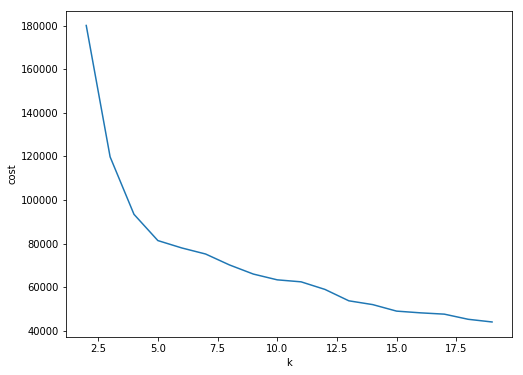

In [48]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [49]:
# Train the machine learning model

k = 500
# kmeans = KMeans(distanceMeasure='cosine').setK(k).setSeed(1).setFeaturesCol("features")
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.         0.         0.02678571 0.01339286 0.02678571 1.        ]
[24.75  5.    0.5   0.25  0.25  6.  ]
[18.   0.2  1.6  0.2  3.8  7.2]
[14.3  1.8  0.   0.   0.3  4.4]
[7.44444444 2.5        0.22222222 0.         0.05555556 2.44444444]
[24.25  2.75  0.25  1.    5.    8.25]
[5.25641026 0.         1.15384615 0.02564103 0.17948718 0.28205128]
[7.         0.13636364 0.06818182 0.13636364 0.06818182 1.        ]
[8.5        0.16666667 2.66666667 0.16666667 0.66666667 0.33333333]
[10.          5.33333333  0.          0.          1.66666667  5.33333333]
[3.         0.         0.         0.         0.02198697 0.        ]
[1.         0.         0.00236106 0.         0.         0.        ]
[3.45714286 3.28571429 0.         0.         0.         0.37142857]
[57.  6.  5.  4.  7. 32.]
[10.29268293  0.04878049  0.07317073  0.07317073  0.          2.65853659]
[3.71428571 2.         2.85714286 0.         0.         2.57142857]
[28.   6.5  5.   1.   4.  13. ]
[22.  4.  4.  0.  1.  8.

In [51]:
# Assign clusters to events

# transformed = model.transform(df_kmeans).select('_c0', 'prediction')
transformed = model.transform(df_kmeans)
print(transformed)
transformed.coalesce(1).write.parquet('comm_pred.parquet')
rows = transformed.collect()
print(rows[:3])

DataFrame[_c0: string, features: vector, prediction: int]
[Row(_c0='1', features=SparseVector(6, {0: 11.0, 4: 2.0}), prediction=62), Row(_c0='2', features=DenseVector([16.0, 3.0, 0.0, 0.0, 1.0, 3.0]), prediction=447), Row(_c0='3', features=DenseVector([38.0, 1.0, 1.0, 2.0, 5.0, 15.0]), prediction=221)]


In [52]:
transformed2 = sqlContext.read.parquet('comm_pred.parquet')
rows = transformed.collect()
print(rows[:3])

[Row(_c0='1', features=SparseVector(6, {0: 11.0, 4: 2.0}), prediction=62), Row(_c0='2', features=DenseVector([16.0, 3.0, 0.0, 0.0, 1.0, 3.0]), prediction=447), Row(_c0='3', features=DenseVector([38.0, 1.0, 1.0, 2.0, 5.0, 15.0]), prediction=221)]


In [53]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show(10)

+---+--------------------+----------+
|_c0|            features|prediction|
+---+--------------------+----------+
|  1|(6,[0,4],[11.0,2.0])|        62|
|  2|[16.0,3.0,0.0,0.0...|       447|
|  3|[38.0,1.0,1.0,2.0...|       221|
|  4|[12.0,2.0,0.0,0.0...|       462|
|  5|(6,[0,5],[11.0,2.0])|       358|
|  6|[13.0,0.0,2.0,0.0...|        37|
|  7|       (6,[0],[9.0])|       103|
|  8|(6,[0,5],[25.0,7.0])|       157|
|  9|[16.0,0.0,0.0,0.0...|        97|
| 10|[13.0,0.0,4.0,0.0...|        20|
+---+--------------------+----------+
only showing top 10 rows



In [54]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.8238568073397577


In [58]:
from pyspark.ml.clustering import KMeansModel
model_path = "/home/vovo/PycharmProjects/etl/commentator_kmeans.model"
model.save(model_path)

In [59]:
model2 = KMeansModel.load(model_path)

In [18]:
# Join the prediction with the original data

# df_pred = df_pred.join(df, '_c0')
# df_pred.show()

In [60]:
# df_pred.filter("prediction = 0").show()
for i in range(500):
    print(df_pred.filter("prediction = " + str(i)).count())

224
4
5
10
18
4
39
44
6
3
1228
5506
35
1
41
7
2
2
3
13
4
5
17
2
1
4
1
4
52
142
2
4
3
3489
1
4
621
7
4
5
22
1
13
31
1
1
2
1
5
2
107
2
39
3
2
3
4
9
3
1
2
12
31
1
5
16
12
1
1
4
1
3
5
1
5
11
12
43
41
53
15
60
5
7
26
293
10
1
11
4
32
34
4
15
12
41
6
6
2
14
15
6
8
52
2
12
1
1
132
14
12
170
13
55
10
16
13
1
1
4
3
20
20
1
4
18
2
9
11
6
5
16
4
10
3
70
4
9
174
45
7
7
2
3
22
1
1
17
1
12
43
12
16
4
95
22
10
8
4
1
85
4
17
17
4
2
40
15
12
1
10
2
1
3
3
131
14
1
4
10
11
6
13
4
6
13
4
12
2
4
129
3
6
1
10
7
4
2
3
3
45
1
1
8
12
66
55
6
9
1
17
6
5
1
7
9
3
8
1
11
11
1
15
11
3
1
3
7
7
9
39
19
2
13
6
9
1
5
27
14
4
1
10
2
1
9
1
46
99
1
15
3
3
1
5
3
1
9
3
1
3
2
6
1
7
50
5
2
5
2
13
9
1
4
11
3
6
2
1
2
14
10
100
25
13
10
1
13
1
12
6
2
7
5
3
4
5
1
2
36
3
3
15
1
5
10
1
7
1
16
4
2
18
29
6
1
1
13
4
20
11
1
1
1
44
1
10
1
2
1
1
15
1
11
2
4
30
1
5
5
3
2
1
3
6
13
3
1
2
9
4
13
2
6
4
4
6
4
39
1
11
43
18
4
3
3
5
15
11
4
1
16
1
1
1
1
25
47
7
3
2
7
1
2
6
5
5
17
1
13
3
4
1
1
3
8
4
5
6
2
4
4
1
2
4
20
15
7
5
1
13
1
11
19
8
3
9
1

In [61]:
df_c1 = df_pred.filter("prediction = 0")
df_c1.show()

# mat = RowMatrix(rows)

+----+--------------------+----------+
| _c0|            features|prediction|
+----+--------------------+----------+
| 484| (6,[0,5],[2.0,1.0])|         0|
| 651| (6,[0,5],[2.0,1.0])|         0|
|1208| (6,[0,5],[2.0,1.0])|         0|
|1455| (6,[0,5],[2.0,1.0])|         0|
|1462| (6,[0,5],[2.0,1.0])|         0|
|1499| (6,[0,5],[2.0,1.0])|         0|
|1543|[2.0,0.0,0.0,0.0,...|         0|
|1592| (6,[0,5],[2.0,1.0])|         0|
|1875| (6,[0,5],[2.0,1.0])|         0|
|1920| (6,[0,5],[2.0,1.0])|         0|
|2151| (6,[0,5],[2.0,1.0])|         0|
|2181| (6,[0,5],[2.0,1.0])|         0|
|2596| (6,[0,5],[2.0,1.0])|         0|
|2628| (6,[0,5],[2.0,1.0])|         0|
|2678| (6,[0,5],[2.0,1.0])|         0|
|2969| (6,[0,5],[2.0,1.0])|         0|
|3160|[2.0,0.0,1.0,0.0,...|         0|
|3536| (6,[0,5],[2.0,1.0])|         0|
|3653| (6,[0,5],[2.0,1.0])|         0|
|3709| (6,[0,5],[2.0,1.0])|         0|
+----+--------------------+----------+
only showing top 20 rows



In [62]:
import random

v = list()
for i in range(100):
    v1 = [None] * 6
    
    for i in range(6):
        v1[i] = float(random.randint(0, 43))
        
    v.append(v1)

print(v)

[[26.0, 9.0, 27.0, 31.0, 28.0, 43.0], [2.0, 4.0, 15.0, 42.0, 17.0, 14.0], [11.0, 28.0, 1.0, 17.0, 21.0, 4.0], [1.0, 36.0, 22.0, 9.0, 19.0, 1.0], [16.0, 41.0, 11.0, 41.0, 12.0, 25.0], [3.0, 5.0, 36.0, 15.0, 36.0, 30.0], [21.0, 41.0, 38.0, 23.0, 41.0, 32.0], [21.0, 37.0, 12.0, 43.0, 10.0, 22.0], [0.0, 34.0, 16.0, 38.0, 19.0, 0.0], [4.0, 15.0, 37.0, 23.0, 23.0, 17.0], [38.0, 30.0, 36.0, 26.0, 39.0, 0.0], [19.0, 10.0, 30.0, 20.0, 39.0, 24.0], [35.0, 34.0, 17.0, 18.0, 4.0, 40.0], [15.0, 16.0, 23.0, 40.0, 13.0, 0.0], [3.0, 26.0, 21.0, 19.0, 39.0, 23.0], [42.0, 35.0, 25.0, 33.0, 26.0, 12.0], [6.0, 10.0, 14.0, 22.0, 31.0, 2.0], [42.0, 34.0, 14.0, 35.0, 2.0, 36.0], [17.0, 20.0, 7.0, 10.0, 37.0, 22.0], [33.0, 37.0, 42.0, 31.0, 35.0, 30.0], [12.0, 8.0, 7.0, 21.0, 15.0, 19.0], [14.0, 26.0, 19.0, 7.0, 6.0, 39.0], [27.0, 17.0, 7.0, 27.0, 9.0, 37.0], [39.0, 17.0, 25.0, 16.0, 2.0, 21.0], [17.0, 32.0, 5.0, 33.0, 14.0, 33.0], [36.0, 28.0, 17.0, 23.0, 18.0, 29.0], [5.0, 12.0, 3.0, 34.0, 2.0, 1.0], [3.0, 

In [63]:
from pyspark.sql import Row

v_rdd = sc.parallelize(v)
v_rdd = v_rdd.map(lambda p: Row(_c0=1, _c1=p[0], _c2=p[1], _c3=p[2], _c4=p[3], _c5=p[4], _c6=p[5]))
v_df = v_rdd.toDF()
v_df.show()

+---+----+----+----+----+----+----+
|_c0| _c1| _c2| _c3| _c4| _c5| _c6|
+---+----+----+----+----+----+----+
|  1|26.0| 9.0|27.0|31.0|28.0|43.0|
|  1| 2.0| 4.0|15.0|42.0|17.0|14.0|
|  1|11.0|28.0| 1.0|17.0|21.0| 4.0|
|  1| 1.0|36.0|22.0| 9.0|19.0| 1.0|
|  1|16.0|41.0|11.0|41.0|12.0|25.0|
|  1| 3.0| 5.0|36.0|15.0|36.0|30.0|
|  1|21.0|41.0|38.0|23.0|41.0|32.0|
|  1|21.0|37.0|12.0|43.0|10.0|22.0|
|  1| 0.0|34.0|16.0|38.0|19.0| 0.0|
|  1| 4.0|15.0|37.0|23.0|23.0|17.0|
|  1|38.0|30.0|36.0|26.0|39.0| 0.0|
|  1|19.0|10.0|30.0|20.0|39.0|24.0|
|  1|35.0|34.0|17.0|18.0| 4.0|40.0|
|  1|15.0|16.0|23.0|40.0|13.0| 0.0|
|  1| 3.0|26.0|21.0|19.0|39.0|23.0|
|  1|42.0|35.0|25.0|33.0|26.0|12.0|
|  1| 6.0|10.0|14.0|22.0|31.0| 2.0|
|  1|42.0|34.0|14.0|35.0| 2.0|36.0|
|  1|17.0|20.0| 7.0|10.0|37.0|22.0|
|  1|33.0|37.0|42.0|31.0|35.0|30.0|
+---+----+----+----+----+----+----+
only showing top 20 rows



In [64]:
# Convert all data columns to float

for col in v_df.columns:
    v_df = v_df.withColumn(col,v_df[col].cast('float'))
v_df.show()
v_df.count()

+---+----+----+----+----+----+----+
|_c0| _c1| _c2| _c3| _c4| _c5| _c6|
+---+----+----+----+----+----+----+
|1.0|26.0| 9.0|27.0|31.0|28.0|43.0|
|1.0| 2.0| 4.0|15.0|42.0|17.0|14.0|
|1.0|11.0|28.0| 1.0|17.0|21.0| 4.0|
|1.0| 1.0|36.0|22.0| 9.0|19.0| 1.0|
|1.0|16.0|41.0|11.0|41.0|12.0|25.0|
|1.0| 3.0| 5.0|36.0|15.0|36.0|30.0|
|1.0|21.0|41.0|38.0|23.0|41.0|32.0|
|1.0|21.0|37.0|12.0|43.0|10.0|22.0|
|1.0| 0.0|34.0|16.0|38.0|19.0| 0.0|
|1.0| 4.0|15.0|37.0|23.0|23.0|17.0|
|1.0|38.0|30.0|36.0|26.0|39.0| 0.0|
|1.0|19.0|10.0|30.0|20.0|39.0|24.0|
|1.0|35.0|34.0|17.0|18.0| 4.0|40.0|
|1.0|15.0|16.0|23.0|40.0|13.0| 0.0|
|1.0| 3.0|26.0|21.0|19.0|39.0|23.0|
|1.0|42.0|35.0|25.0|33.0|26.0|12.0|
|1.0| 6.0|10.0|14.0|22.0|31.0| 2.0|
|1.0|42.0|34.0|14.0|35.0| 2.0|36.0|
|1.0|17.0|20.0| 7.0|10.0|37.0|22.0|
|1.0|33.0|37.0|42.0|31.0|35.0|30.0|
+---+----+----+----+----+----+----+
only showing top 20 rows



100

In [65]:
# Create a features column to be used in the clustering
FEATURES_COL = ['_c1', '_c2', '_c3', '_c4', '_c5', '_c6']
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
v_df = vecAssembler.transform(v_df).select('_c0', 'features')
v_df.show()

+---+--------------------+
|_c0|            features|
+---+--------------------+
|1.0|[26.0,9.0,27.0,31...|
|1.0|[2.0,4.0,15.0,42....|
|1.0|[11.0,28.0,1.0,17...|
|1.0|[1.0,36.0,22.0,9....|
|1.0|[16.0,41.0,11.0,4...|
|1.0|[3.0,5.0,36.0,15....|
|1.0|[21.0,41.0,38.0,2...|
|1.0|[21.0,37.0,12.0,4...|
|1.0|[0.0,34.0,16.0,38...|
|1.0|[4.0,15.0,37.0,23...|
|1.0|[38.0,30.0,36.0,2...|
|1.0|[19.0,10.0,30.0,2...|
|1.0|[35.0,34.0,17.0,1...|
|1.0|[15.0,16.0,23.0,4...|
|1.0|[3.0,26.0,21.0,19...|
|1.0|[42.0,35.0,25.0,3...|
|1.0|[6.0,10.0,14.0,22...|
|1.0|[42.0,34.0,14.0,3...|
|1.0|[17.0,20.0,7.0,10...|
|1.0|[33.0,37.0,42.0,3...|
+---+--------------------+
only showing top 20 rows



In [66]:
transformed = model2.transform(v_df)
rows = transformed.collect()
print(rows[:])

[Row(_c0=1.0, features=DenseVector([26.0, 9.0, 27.0, 31.0, 28.0, 43.0]), prediction=165), Row(_c0=1.0, features=DenseVector([2.0, 4.0, 15.0, 42.0, 17.0, 14.0]), prediction=145), Row(_c0=1.0, features=DenseVector([11.0, 28.0, 1.0, 17.0, 21.0, 4.0]), prediction=393), Row(_c0=1.0, features=DenseVector([1.0, 36.0, 22.0, 9.0, 19.0, 1.0]), prediction=272), Row(_c0=1.0, features=DenseVector([16.0, 41.0, 11.0, 41.0, 12.0, 25.0]), prediction=249), Row(_c0=1.0, features=DenseVector([3.0, 5.0, 36.0, 15.0, 36.0, 30.0]), prediction=453), Row(_c0=1.0, features=DenseVector([21.0, 41.0, 38.0, 23.0, 41.0, 32.0]), prediction=87), Row(_c0=1.0, features=DenseVector([21.0, 37.0, 12.0, 43.0, 10.0, 22.0]), prediction=249), Row(_c0=1.0, features=DenseVector([0.0, 34.0, 16.0, 38.0, 19.0, 0.0]), prediction=272), Row(_c0=1.0, features=DenseVector([4.0, 15.0, 37.0, 23.0, 23.0, 17.0]), prediction=272), Row(_c0=1.0, features=DenseVector([38.0, 30.0, 36.0, 26.0, 39.0, 0.0]), prediction=44), Row(_c0=1.0, features=Den

In [67]:
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.mllib.linalg import Vectors

df_c1 = df_pred.filter("prediction = 0").select('_c0', 'features')
# for col in ["features"]:
#     df_c1 = df_c1.withColumn(col,Vectors.dense(v_df[col]))
# df_c1.show()

v_df_c1 = v_df.select("features")
v_df_c1.show(truncate=False)

+-------------------------------+
|features                       |
+-------------------------------+
|[26.0,9.0,27.0,31.0,28.0,43.0] |
|[2.0,4.0,15.0,42.0,17.0,14.0]  |
|[11.0,28.0,1.0,17.0,21.0,4.0]  |
|[1.0,36.0,22.0,9.0,19.0,1.0]   |
|[16.0,41.0,11.0,41.0,12.0,25.0]|
|[3.0,5.0,36.0,15.0,36.0,30.0]  |
|[21.0,41.0,38.0,23.0,41.0,32.0]|
|[21.0,37.0,12.0,43.0,10.0,22.0]|
|[0.0,34.0,16.0,38.0,19.0,0.0]  |
|[4.0,15.0,37.0,23.0,23.0,17.0] |
|[38.0,30.0,36.0,26.0,39.0,0.0] |
|[19.0,10.0,30.0,20.0,39.0,24.0]|
|[35.0,34.0,17.0,18.0,4.0,40.0] |
|[15.0,16.0,23.0,40.0,13.0,0.0] |
|[3.0,26.0,21.0,19.0,39.0,23.0] |
|[42.0,35.0,25.0,33.0,26.0,12.0]|
|[6.0,10.0,14.0,22.0,31.0,2.0]  |
|[42.0,34.0,14.0,35.0,2.0,36.0] |
|[17.0,20.0,7.0,10.0,37.0,22.0] |
|[33.0,37.0,42.0,31.0,35.0,30.0]|
+-------------------------------+
only showing top 20 rows



In [27]:
# df_vw = df_c1.join(v_df_c1, df_c1.features == v_df_c1.features, "left")
# df_vw.show()

+-----+--------------------+--------+
|  _c0|            features|features|
+-----+--------------------+--------+
| 1543|[2.0,0.0,0.0,0.0,...|    null|
| 4746|[2.0,0.0,0.0,0.0,...|    null|
|10730|[2.0,0.0,0.0,0.0,...|    null|
|12638|[2.0,0.0,0.0,0.0,...|    null|
|13668|[2.0,0.0,0.0,0.0,...|    null|
|15433|[2.0,0.0,0.0,0.0,...|    null|
| 4830|[2.0,0.0,0.0,1.0,...|    null|
| 7678|[2.0,0.0,0.0,1.0,...|    null|
|13872|[2.0,0.0,0.0,1.0,...|    null|
|  484| (6,[0,5],[2.0,1.0])|    null|
|  651| (6,[0,5],[2.0,1.0])|    null|
| 1208| (6,[0,5],[2.0,1.0])|    null|
| 1455| (6,[0,5],[2.0,1.0])|    null|
| 1462| (6,[0,5],[2.0,1.0])|    null|
| 1499| (6,[0,5],[2.0,1.0])|    null|
| 1592| (6,[0,5],[2.0,1.0])|    null|
| 1875| (6,[0,5],[2.0,1.0])|    null|
| 1920| (6,[0,5],[2.0,1.0])|    null|
| 2151| (6,[0,5],[2.0,1.0])|    null|
| 2181| (6,[0,5],[2.0,1.0])|    null|
+-----+--------------------+--------+
only showing top 20 rows



In [68]:
import numpy as np
import math
from pyspark.sql.types import DecimalType
from pyspark.sql.functions import udf

def cos_sim(v,w):
    # v,w is a vector, return the cosine between the two vectors,
    # value between -1~1
    
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v)):
        x = v[i]; y = w[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)
    
#     return np.dot(v,w)/(math.sqrt(np.dot(v,v) * np.dot(w,w)))

#spark.udf.register("c_s", cos_sim, DecimalType())
#similarity = udf(lambda z: cos_sim(z), DecimalType())
#similarity = udf(cos_sim, DecimalType())

In [49]:
# u_vec = [1.0,2.0,3.0,4.0,5.0,6.0]

# df_vw = df_c1.select("_c0", similarity(list([1.0,2.0,3.0,4.0,5.0,6.0]), df_c1.features)
#                      .alias("similarity"))
# df_vw.printSchema()

# df_vw.show()

TypeError: Invalid argument, not a string or column: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] of type <class 'list'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [69]:
list_c1 = df_c1.rdd.collect()
# mvv_array = [int(row.mvv) for row in list_c1.collect()]
# mvv = mvv_count_df.select("mvv").rdd.flatMap(lambda x: x).collect()
# print(list_c1[0][1])
# print(Vectors.dense(list_c1[0][1]))
# print(type(Vectors.dense(list_c1[0][1])))
# print( type(Vectors.dense(list_c1[0][1]).values) )
v_vec = Vectors.dense(list_c1[0][1]).values
u_vec = [1.0,2.0,3.0,4.0,5.0,6.0]
# print(type(u_vec))
best_id = ""
best_value = -2
for i in range(len(list_c1)):
#     print(type(list_c1[i][1]))
    v_vec = Vectors.dense(list_c1[i][1]).values
    sim = cos_sim(v_vec, u_vec)
    print(list_c1[i][0], sim)
    
    if sim > best_value:
        best_id = list_c1[i][0]
        best_value = sim
        
print(best_id, best_value)

# a = cos_sim(u_vec,u_vec)
# print(a)

484 0.3750457847507963
651 0.3750457847507963
1208 0.3750457847507963
1455 0.3750457847507963
1462 0.3750457847507963
1499 0.3750457847507963
1543 0.5563486402641867
1592 0.3750457847507963
1875 0.3750457847507963
1920 0.3750457847507963
2151 0.3750457847507963
2181 0.3750457847507963
2596 0.3750457847507963
2628 0.3750457847507963
2678 0.3750457847507963
2969 0.3750457847507963
3160 0.47075654176200415
3536 0.3750457847507963
3653 0.3750457847507963
3709 0.3750457847507963
4087 0.3750457847507963
4264 0.47075654176200415
4279 0.3750457847507963
4303 0.3750457847507963
4431 0.3750457847507963
4560 0.3750457847507963
4618 0.3750457847507963
4746 0.5563486402641867
4830 0.5135525910130955
5183 0.3750457847507963
5263 0.3750457847507963
5475 0.3750457847507963
5500 0.3750457847507963
5595 0.3750457847507963
5718 0.3750457847507963
5762 0.3750457847507963
5777 0.3750457847507963
5786 0.3750457847507963
5826 0.3750457847507963
5951 0.3750457847507963
6036 0.3750457847507963
6047 0.375045784

In [ ]:
# df.withColumn('val2', simpleUdf('val', f.lit(2))).show()
# df.withColumn('val2', simpleUdf('val', 2)).show()

In [ ]:
# x=np.array([[31.0,27.0,27.0,4.0,36.0,2.0]])
# y=np.array([[21.0,17.0,41.0,25.0,27.0,24.0]])
# # x.reshape(1,-1)
# # print(cosine_similarity(Vectors.dense(df_c1.features), Vectors.dense(v_df_c1.features)))
# print(cosine_similarity(x,y))
# print(cosine_similarity([[31.0,27.0,27.0,4.0,36.0,2.0],[21.0,17.0,41.0,25.0,27.0,24.0]]))